In [1]:
import os
import sys
# in order to load the code located in parent directory as a package
orig_dir = os.getcwd()
package_dir = os.path.join(os.path.dirname(os.getcwd()))
sys.path.insert(0, package_dir)

In [8]:
from stresspred import (code_paths,
                        P5_StressDataLoader, 
                        P5M5DataLoader, 
                        hb_extract, 
                        peak_time_to_rri, 
                        resample_nonuniform, 
                        find_local_hb_peaks,
                       timestamp_to_samp,
                       samp_to_timestamp)

In [9]:
for path in code_paths["neurokit2_paths"]:
    sys.path.insert(0, path)
import neurokit2 as nk

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from json_tricks import dump, dumps, load, loads

In [11]:
out_parent_path_rstr = r"Z:\Shared\Documents\RD\RD2\_Projets\Pascal\P5 In-Ear Biosignal Monitoring\DanielleEersBridge\P5_Stress_label\_gitSave\hb_extraction\rests_1sub_P5_M5_3\json_files"
out_parent_path = os.path.join(*out_parent_path_rstr.split("\\"))
if not os.path.exists(out_parent_path):
    os.makedirs(out_parent_path)

In [12]:
min_bpm = 40
max_bpm = 200
interval_min = 60/max_bpm
interval_max = 60/min_bpm
            
for sub_id in [3]:
    out_path = os.path.join(out_parent_path, "out" + str(sub_id) + ".json")
    out = {}
    rest_labels = ["01_preSilence"]
    for label in rest_labels:
        out[label] = {}
        for sig_name in ["zephyr_ecg", "ieml"]:
            sig_info = P5M5DataLoader(sub_id=3, cond_label="01_preSilence").get_sig(sig_name=sig_name)
            sig_info["peak_time"] = hb_extract(sig=sig_info["sig"], sig_time=sig_info["time"], sig_name=sig_info["name"])
            sig_info["cor_peak_time"] = find_local_hb_peaks(sig_info["peak_time"], 
                                 sig=sig_info["sig"], 
                                 sig_time=sig_info["time"], 
                                 sampling_rate=sig_info["sampling_rate"], 
                                 check_height_outlier=True)
            samp = timestamp_to_samp(sig_info["cor_peak_time"], sig_info["sampling_rate"], sig_info["time"])
            clean_peak_samp = nk.signal_fixpeaks(
                samp,
                sampling_rate=sig_info["sampling_rate"],
                interval_min=interval_min, interval_max=interval_max, method="neurokit")
            clean_peak_time = samp_to_timestamp(clean_peak_samp, sig_time=sig_info["time"])
            cor_clean_peak_time = find_local_hb_peaks(clean_peak_time, 
                     sig=sig_info["sig"], 
                     sig_time=sig_info["time"], 
                     sampling_rate=sig_info["sampling_rate"], 
                     check_height_outlier=True)
            sig_info["cor_clean_peak_time"] = cor_clean_peak_time
            out[label][sig_name] = sig_info 
            with open(out_path, "w") as json_file:
                dump(out, json_file)

In [13]:
json_paths = [ f.path for f in os.scandir(out_parent_path) if "out" in f.path and ".json" in f.path ]

In [15]:
out_figure_dir_path_rstr = r"Z:\Shared\Documents\RD\RD2\_Projets\Pascal\P5 In-Ear Biosignal Monitoring\DanielleEersBridge\P5_Stress_label\_gitSave\hb_extraction\rests_1sub_P5_M5_3\figures"
out_figure_dir_path = os.path.join(*out_figure_dir_path_rstr.split("\\"))
if not os.path.exists(out_figure_dir_path):
    os.makedirs(out_figure_dir_path)

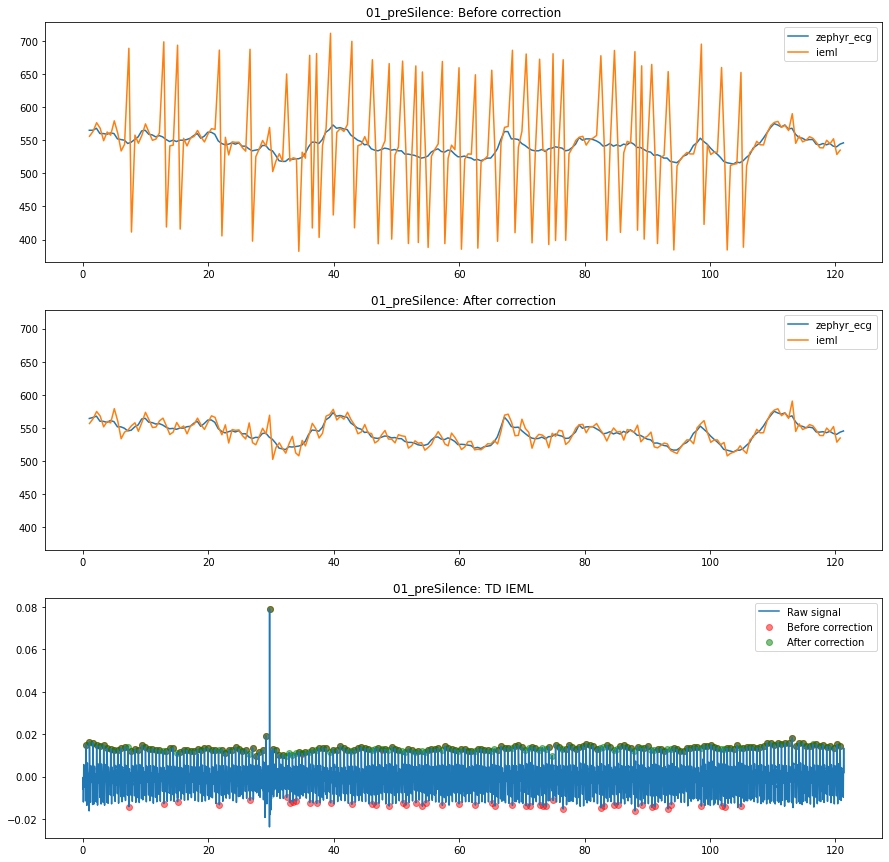

In [17]:
for json_path in json_paths:
    with open(json_path, "r") as json_file:
        data = load(json_file)
    for rest in data.keys():
        file_name_start = os.path.splitext(os.path.basename(json_path))[0]
        fig_file_name = file_name_start + "_" + rest + "_peak_cor.png"
        fig_file_path = os.path.join(out_figure_dir_path, fig_file_name)
        sig_names = data[rest].keys()
        fig = plt.figure(figsize=(15,15))
        ax1 = fig.add_subplot(311)
        for sig_name in sig_names:
            rri, rri_time = peak_time_to_rri(data[rest][sig_name]["peak_time"])
            ax1.plot(rri_time, rri)
        ax1.legend(sig_names)
        ax1.set_title(rest + ": Before correction")
        ax2 = fig.add_subplot(312, sharey=ax1, sharex=ax1)   
        for sig_name in sig_names:
            rri, rri_time = peak_time_to_rri(data[rest][sig_name]["cor_peak_time"])
            ax2.plot(rri_time, rri)
        ax2.set_title(rest + ": After correction")
        ax2.legend(sig_names)
        sig_info = data[rest]["ieml"]
        sig=sig_info["sig"]
        sig_time=sig_info["time"]
        sampling_rate=sig_info["sampling_rate"]
        peaks = sig_info["peak_time"]
        new_peaks = sig_info["cor_peak_time"]
        ax3 = fig.add_subplot(313, sharex=ax1)   
        ax3.plot(sig_time, sig)
        samp = timestamp_to_samp(peaks, sampling_rate, sig_time)
        peaks = peaks[samp > 0]
        samp = samp[samp > 0]
        ax3.scatter(peaks,
                    sig[samp], color="red", alpha=0.5)
        samp = timestamp_to_samp(new_peaks, sampling_rate, sig_time)
        new_peaks = new_peaks[samp > 0]
        samp = samp[samp > 0]
        ax3.set_title(rest + ": TD IEML")
        ax3.scatter(new_peaks,
                    sig[samp], color="green", alpha=0.5)
        ax3.legend(["Raw signal","Before correction", "After correction"])
        plt.savefig(fig_file_path)
        plt.show()

In [5]:
sig_names = ["zephyr_ecg","ieml"]
sig_infos = []
hb_infos = []

for sig_name in sig_names:
    sig_info = P5M5DataLoader(sub_id=3, cond_label="01_preSilence").get_sig(sig_name=sig_name)
    sig_infos.append(sig_info)
    peak_time = hb_extract(sig=sig_info["sig"], sampling_rate=sig_info["sampling_rate"], sig_name=sig_name)
    hb_info = peak_time_to_rri(peak_time)
    hb_info["sig_name"] = sig_name
    hb_infos.append(hb_info)

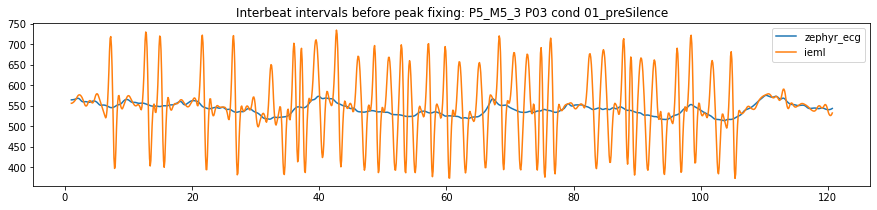

In [125]:
new_sampling_rate = 10
fig = plt.figure(figsize=(15,3))
resamp_rris = []
for hb_info in hb_infos:
    rri = hb_info["rri"]
    rri_time = hb_info["rri_time"]
    resamp_rri_time, resamp_rri = resample_nonuniform(
        x_old=rri_time, y_old=rri, sampling_rate=new_sampling_rate, method="linear")
    resamp_rris.append(resamp_rri)
    plt.plot(resamp_rri_time, resamp_rri)
    
plt.legend(legend)
plt.title("Interbeat intervals before peak fixing: P5_M5_3 P03 cond 01_preSilence")
plt.show()

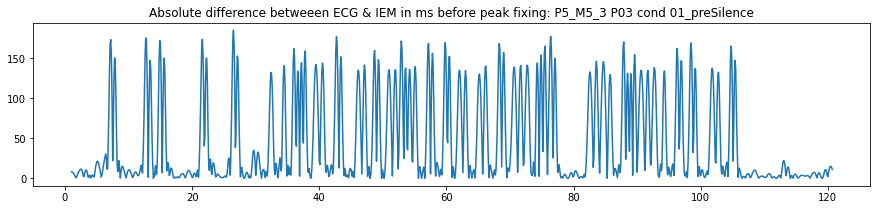

In [127]:
fig = plt.figure(figsize=(15,3))
shift_samples = 0
plt.plot(resamp_rri_time[0:len(resamp_rris[0][shift_samples:])],
         np.abs(resamp_rris[0][shift_samples:] - resamp_rris[1][0:len(resamp_rris[0][shift_samples:])]))
plt.title("Absolute difference betweeen ECG & IEM in ms before peak fixing: P5_M5_3 P03 cond 01_preSilence")
plt.show()

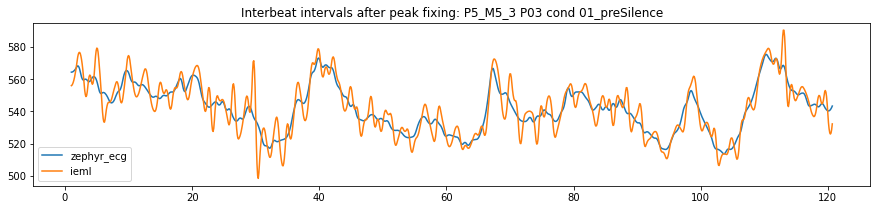

In [128]:
from neurokit2.signal import signal_interpolate
new_sampling_rate = 10
fig = plt.figure(figsize=(15,3))
resamp_rris = []
for hb_info in [hb_infos[0]]:
    rri = hb_info["rri"]
    rri_time = hb_info["rri_time"]
    resamp_rri_time, resamp_rri = resample_with_uneven_times(
        x_old=rri_time, y_old=rri, sampling_rate=new_sampling_rate, method="linear")
    resamp_rris.append(resamp_rri)
    plt.plot(resamp_rri_time, resamp_rri)
    
hb_info = peak_time_to_rri(new_peak_time)
rri = hb_info["rri"]
rri_time = hb_info["rri_time"]
resamp_rri_time, resamp_rri = resample_with_uneven_times(
        x_old=rri_time, y_old=rri, sampling_rate=new_sampling_rate, method="linear")
resamp_rris.append(resamp_rri)
plt.plot(resamp_rri_time, resamp_rri)
legend.append("new peak time")
plt.legend(legend)
plt.title("Interbeat intervals after peak fixing: P5_M5_3 P03 cond 01_preSilence")
#plt.xlim([10,30])
plt.show()

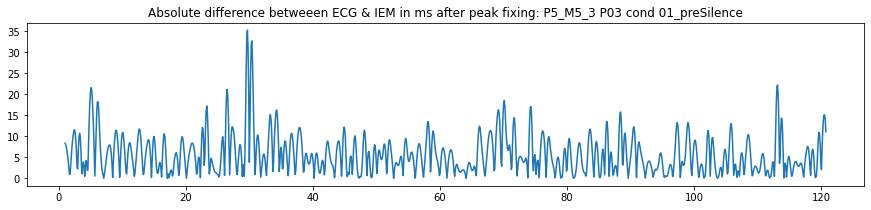

In [129]:
fig = plt.figure(figsize=(15,3))
shift_samples = 0
plt.plot(resamp_rri_time[0:len(resamp_rris[0][shift_samples:])],
         np.abs(resamp_rris[0][shift_samples:] - resamp_rris[1][0:len(resamp_rris[0][shift_samples:])]))
plt.title("Absolute difference betweeen ECG & IEM in ms after peak fixing: P5_M5_3 P03 cond 01_preSilence")
plt.show()

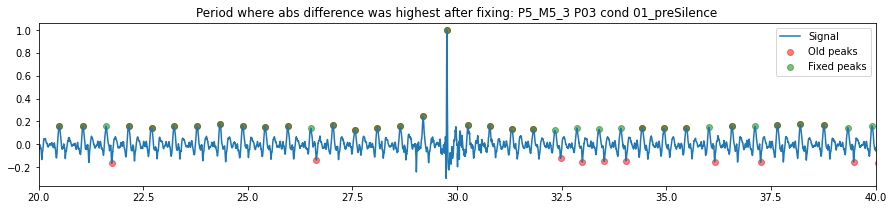

In [138]:
fig = plt.figure(figsize=(15,3))
i = 1
sig_info = sig_infos[i]
hb_info = hb_infos[i]
norm_sig = sig_info["sig"]/np.max(sig_info["sig"])
plt.plot(sig_info["time"], sig_info["sig"]/np.max(sig_info["sig"]))
# need to adjust if time doesn't start at zero
plt.scatter(peak_time, norm_sig[np.array(peak_time*sig_info["sampling_rate"]).astype(int)], alpha=0.5, color="red")
plt.scatter(new_peak_time, norm_sig[np.array(new_peak_time*sig_info["sampling_rate"]).astype(int)], alpha=0.5, color="green")
plt.title("Period where abs difference was highest after fixing: P5_M5_3 P03 cond 01_preSilence")
plt.legend(["Signal","Old peaks", "Fixed peaks"])
plt.xlim([20,40])
plt.show()

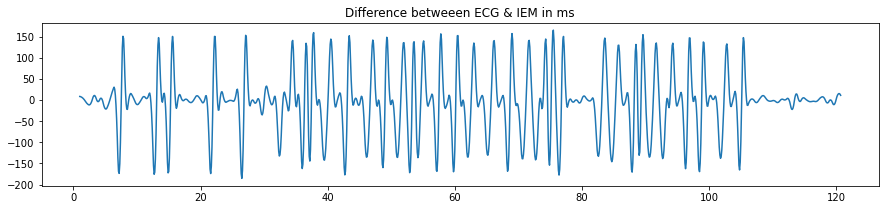

In [70]:
fig = plt.figure(figsize=(15,3))
shift_samples = 0
plt.plot(resamp_rri_time[0:len(resamp_rris[0][shift_samples:])],
         resamp_rris[0][shift_samples:] - resamp_rris[1][0:len(resamp_rris[0][shift_samples:])])
plt.title("Difference betweeen ECG & IEM in ms")
plt.show()

In [ ]:
# try fixing peaks by taking maximum 200ms before and 150ms after 
# with percentile thing for max every second/every period corresponding to a hb

In [15]:
data = [1, 2, 3]
if type(data) is list:
        data = np.array(data)
left_threshold = 1
right_threshold = 3

outliers = (data > left_threshold) & (data < right_threshold)
outliers = data > left_threshold

In [4]:
from stresspred import code_paths
for path in code_paths["neurokit2_paths"]:
    sys.path.insert(0, path)

import neurokit2 as nk    

In [1]:
argmax([1,2,3])

NameError: name 'argmax' is not defined

In [9]:
np.percentile([1, 2, 1, 5, 666, 4, 1 ,3, 5], 0.05)

1.0

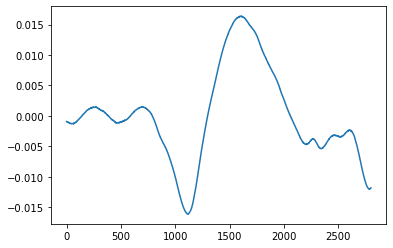

In [74]:
#for peak in peak_time:
peak = peak_time[1]
plt.plot(sig_info["sig"][np.where((sig_info["time"] > peak - 0.2) & (sig_info["time"] < peak + 0.15))])

In [7]:
sig_names = ["zephyr_ecg","ieml"]
sig_infos = []

for sig_name in sig_names:
    sig_info = P5M5DataLoader(sub_id=3, cond_label="01_preSilence").get_sig(sig_name=sig_name)
    
    peak_time = hb_extract(sig=sig_info["sig"], sampling_rate=sig_info["sampling_rate"], sig_name=sig_name)
    sig_info["peak_time"] = peak_time
    """
    rri, rri_time = peak_time_to_rri(peak_time)
    sig_info["rri"] = rri
    sig_info["rri_time"] = rri_time
    """
    sig_infos.append(sig_info)

In [8]:
sig_info = sig_infos[1]

In [9]:
new_peak_time = []
peak_height = sig_info["sig"][np.array(peak_time*sig_info["sampling_rate"]).astype(int)]
for peak in peak_time:
    sub_sig_indices = np.where((sig_info["time"] > peak - 0.2) & (sig_info["time"] < peak + 0.15))
    sub_sig = sig_info["sig"][sub_sig_indices]
    sub_time = sig_info["time"][sub_sig_indices]
    new_peak = sub_time[np.argmax(sub_sig)]
    
    if np.max(sub_sig) < np.percentile(peak_height, 75):
        new_peak_time.append(new_peak)
    else:
        new_peak_time.append(peak)
new_peak_time = np.array(new_peak_time)

In [12]:
new_peak_time = find_local_hb_peaks(sig_info["peak_time"], 
                     sig=sig_info["sig"], 
                     sig_time=sig_info["time"], 
                     sampling_rate=sig_info["sampling_rate"])


In [13]:
len(new_peak_time)

223

In [15]:
norm_sig = sig_info["sig"]/np.max(sig_info["sig"])
len(norm_sig[np.array(new_peak_time*sig_info["sampling_rate"]).astype(int)])

223

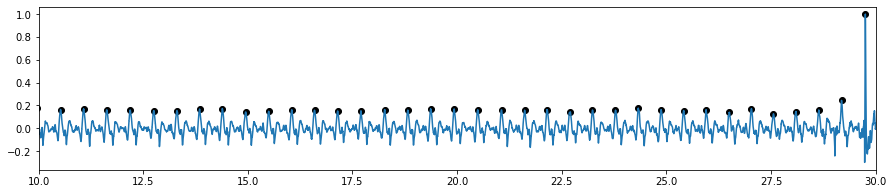

In [18]:
fig = plt.figure(figsize=(15,3))
i = 1
sig_info = sig_infos[i]
norm_sig = sig_info["sig"]/np.max(sig_info["sig"])
plt.plot(sig_info["time"], sig_info["sig"]/np.max(sig_info["sig"]))
# need to adjust if time doesn't start at zero
plt.scatter(new_peak_time, norm_sig[np.array(new_peak_time*sig_info["sampling_rate"]).astype(int)], color="black")
plt.xlim([10, 30])
plt.show()

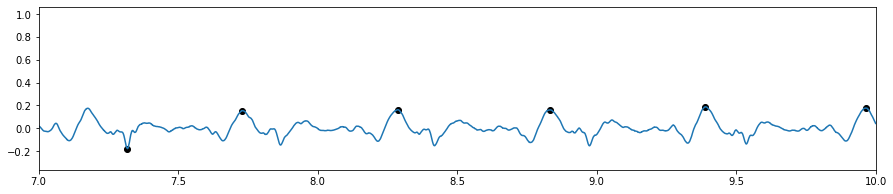

In [76]:
fig = plt.figure(figsize=(15,3))
i = 1
sig_info = sig_infos[i]
hb_info = hb_infos[i]
norm_sig = sig_info["sig"]/np.max(sig_info["sig"])
plt.plot(sig_info["time"], sig_info["sig"]/np.max(sig_info["sig"]))
# need to adjust if time doesn't start at zero
plt.scatter(peak_time, norm_sig[np.array(peak_time*sig_info["sampling_rate"]).astype(int)], color="black")
plt.xlim([7,10])
plt.show()

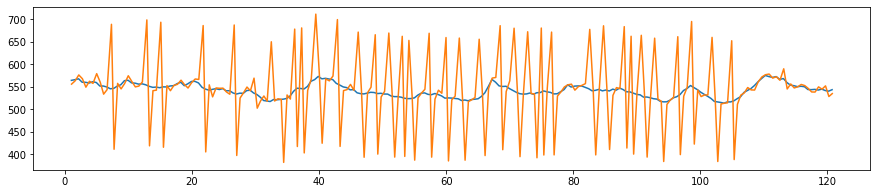

In [16]:
fig = plt.figure(figsize=(15,3))
legend = []
for hb_info in hb_infos:
    plt.plot(hb_info["rri_time"], hb_info["rri"])
    legend.append(hb_info["sig_name"])
plt.title("Dataset: " )
plt.show()

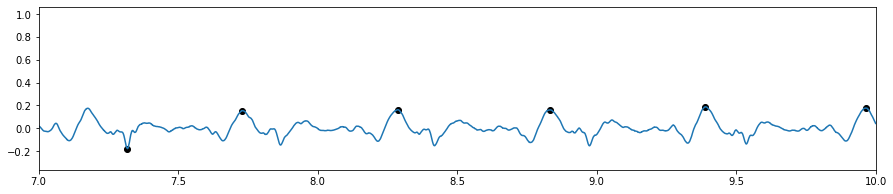

In [67]:
fig = plt.figure(figsize=(15,3))
i = 1
sig_info = sig_infos[i]
hb_info = hb_infos[i]
norm_sig = sig_info["sig"]/np.max(sig_info["sig"])
plt.plot(sig_info["time"], sig_info["sig"]/np.max(sig_info["sig"]))
# need to adjust if time doesn't start at zero
plt.scatter(hb_info["rri_time"], norm_sig[np.array(hb_info["rri_time"]*sig_info["sampling_rate"]).astype(int)], color="black")
plt.xlim([7,10])
plt.show()

(40.0, 45.0)

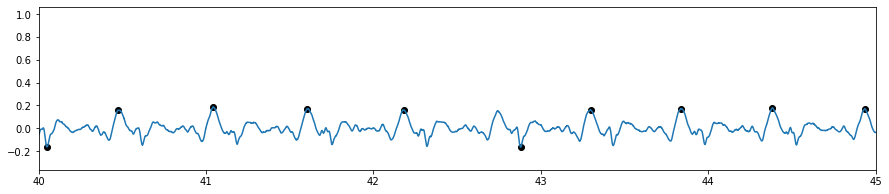

In [68]:
fig = plt.figure(figsize=(15,3))
i = 1
sig_info = sig_infos[i]
hb_info = hb_infos[i]
norm_sig = sig_info["sig"]/np.max(sig_info["sig"])
plt.plot(sig_info["time"], sig_info["sig"]/np.max(sig_info["sig"]))
# need to adjust if time doesn't start at zero
plt.scatter(hb_info["rri_time"], norm_sig[np.array(hb_info["rri_time"]*sig_info["sampling_rate"]).astype(int)], color="black")
plt.xlim([40,45])

In [ ]:
from neurokit2.signal import signal_interpolate
new_sampling_rate = 10
fig = plt.figure(figsize=(15,3))
resamp_rris = []
for hb_info in hb_infos:
    rri = hb_info["rri"]
    rri_time = hb_info["rri_time"]
    resamp_rri_time, resamp_rri = resample_with_uneven_times(
        x_old=rri_time, y_old=rri, sampling_rate=new_sampling_rate, method="quadratic")
    resamp_rris.append(resamp_rri)
    plt.plot(resamp_rri_time, resamp_rri)
plt.legend(legend)
plt.title("Interbeat intervals before synchronization")
plt.show()

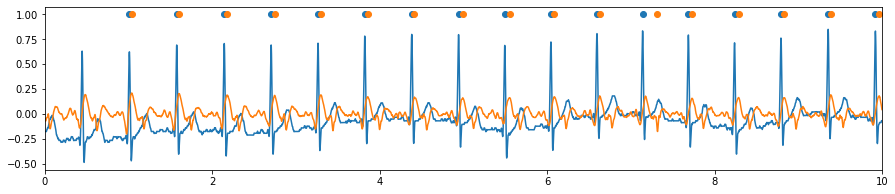

In [21]:
fig = plt.figure(figsize=(15,3))
for i in range(len(sig_infos)):
    sig_info = sig_infos[i]
    hb_info = hb_infos[i]
    plt.plot(sig_info["time"], sig_info["sig"]/np.max(sig_info["sig"]))
    plt.scatter(hb_info["rri_time"], np.ones_like(hb_info["rri_time"]))
    plt.xlim([0,10])
plt.show()

In [ ]:
plt.plot(sig_info["time"])

In [34]:
import pywt
import scipy
signal = sig_info["sig"]
sampling_rate = sig_info["sampling_rate"]
signal_length = len(signal)
swt_level = 3
padding = -1

max_padding = 1000
min_padding = 20
paddings = np.arange(min_padding, max_padding, 1)
for i in paddings:
    if (len(signal) + i*2) % 2 ** swt_level == 0:
        padding = i
        break

if padding > 0:
    signal = np.pad(signal, (padding, padding), "symmetric")
elif padding == -1:
    print("Padding greater than"+ str(max_padding)+"required\n")

swt_ecg = pywt.swt(signal, "db3", level=swt_level)
swt_ecg = np.array(swt_ecg)
swt_ecg = swt_ecg[0, 1, :]
squared = swt_ecg * swt_ecg

squared = squared[padding:padding+signal_length]

f1 = 0.01 / (0.5 * sampling_rate)
f2 = 10 / (0.5 * sampling_rate)

sos = scipy.signal.butter(3, [f1, f2], btype="bandpass", output="sos")
filtered_squared = scipy.signal.sosfilt(sos, squared)

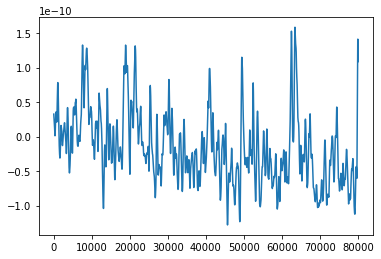

In [48]:
plt.plot(filtered_squared[sampling_rate*10:sampling_rate*20])
#plt.ylim([0, np.percentile(filtered_squared,50)])
#plt.xlim([100,200])

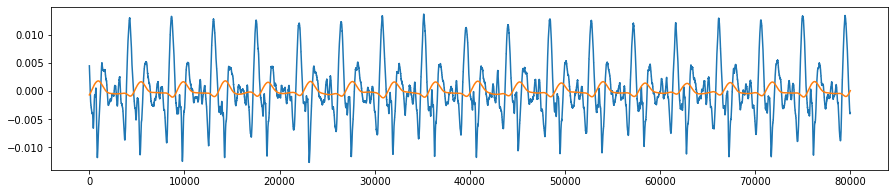

In [54]:
fig = plt.figure(figsize=(15,3))
f1 = 0.01 / (0.5 * sampling_rate)
f2 = 2 / (0.5 * sampling_rate)
sos = scipy.signal.butter(3, [f1, f2], btype="bandpass", output="sos")
filtered_signal = scipy.signal.sosfilt(sos, signal)
plt.plot(signal[sampling_rate*10:sampling_rate*20])
plt.plot(filtered_signal[sampling_rate*10:sampling_rate*20])

#plt.ylim([0, np.percentile(filtered_squared,50)])
#plt.xlim([100,200])